In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import torch
from torchvision.ops.boxes import box_iou

In [2]:
class Matrix:
    def __init__(self,
        data_file: str=r'//aka/work/hara.e/AMED/lib/dataset/annotations/test.json',
        preds_file: str=r'//aka/work/hara.e/AMED/weights/YOLOX/four/metric0.4.json',
    ):
        with open(preds_file, "r") as f:
            self.preds = json.load(f)
        with open(data_file, "r") as f:
            self.data = json.load(f)['annotations']

In [3]:
mat = Matrix(preds_file=r"//aka/work/hara.e/AMED/weights/CenterNet/stepwise2/metric0.4.json")

In [4]:
data = {"id": [], "category_id": [], "bbox": []}

for d in mat.data:
    data["id"].append(d["id"])
    data["category_id"].append(d["category_id"])
    data["bbox"].append(d["bbox"])

data = pd.DataFrame(data)
data

,id,category_id,bbox
0,0,1,"[317.5, 417.5, 164.0, 164.0]"
1,5,1,"[416.5, 422.5, 128.0, 128.0]"
2,14,3,"[361.5, 273.5, 108.0, 108.0]"
3,20,4,"[358.5, 293.5, 292.0, 292.0]"
4,44,1,"[548.5, 367.5, 76.0, 76.0]"
...,...,...,...
8386,83868,1,"[447.5, 288.5, 238.0, 238.0]"
8387,83879,1,"[396.5, 197.5, 162.0, 162.0]"
8388,83880,1,"[432.5, 395.5, 64.0, 64.0]"
8389,83895,1,"[352.5, 346.5, 72.0, 72.0]"


In [5]:
preds = {"file_name": [], "preds": [], "reliability": [], "bbox": []}

for f, p, r, b in zip(mat.preds["file_name"], mat.preds["preds"], mat.preds["reliability"], mat.preds["bbox"]):
    preds["file_name"].append(f)
    preds["preds"].append(p)
    preds["reliability"].append(r)
    preds["bbox"].append(b)

preds = pd.DataFrame(preds)
preds

,file_name,preds,reliability,bbox
0,000000.jpg,[1],[0.8435400128364563],"[[353.1447448730469, 443.26898193359375, 455.7..."
1,000005.jpg,[1],[0.6410096287727356],"[[444.5876159667969, 448.83563232421875, 510.8..."
2,000014.jpg,[3],[0.8789351582527161],"[[381.2187805175781, 290.2698974609375, 453.99..."
3,000020.jpg,"[4, 4]","[0.8628953099250793, 0.7508671283721924]","[[395.52850341796875, 334.54034423828125, 612...."
4,000044.jpg,[0],[0.0],[[]]
...,...,...,...,...
8386,083868.jpg,"[1, 1]","[0.927270770072937, 0.7985350489616394]","[[477.08612060546875, 322.5389099121094, 650.5..."
8387,083879.jpg,[1],[0.958954393863678],"[[329.6592102050781, 134.15313720703125, 617.9..."
8388,083880.jpg,[1],[0.9043828845024109],"[[408.8200378417969, 372.0708923339844, 523.76..."
8389,083895.jpg,[1],[0.8744894862174988],"[[354.41168212890625, 344.5730895996094, 435.6..."


In [6]:
preds.iloc[9]

file_name                                             000104.jpg
preds                                                        [1]
reliability                                 [0.8457605242729187]
bbox           [[292.53631591796875, 453.4455261230469, 382.2...
Name: 9, dtype: object

In [7]:
def calc_iou(pred: list, label: list) -> list:
    x, y, w, h = label
    if pred != [[]]:
        pred, label = torch.Tensor(pred), torch.Tensor([[x, y, x + w, y + h]])
        iou = box_iou(pred, label)
    else:
        iou = torch.Tensor([[0.]])
    return iou.flatten().tolist()

df_iou = {"iou": []}
for i in range(len(preds)):
    iou = calc_iou(preds.iloc[i]["bbox"], data.iloc[i]["bbox"])
    df_iou["iou"].append(iou)
df_iou = pd.DataFrame(df_iou)
df_iou

,iou
0,[0.39239001274108887]
1,[0.2641383111476898]
2,[0.4530755579471588]
3,"[0.5454360246658325, 0.11127623915672302]"
4,[0.0]
...,...
8386,"[0.5335068106651306, 0.0]"
8387,[0.3161921203136444]
8388,[0.3088900148868561]
8389,[0.7420859932899475]


In [8]:
preds["label"] = data["category_id"]
preds["iou"] = df_iou["iou"]
preds

,file_name,preds,reliability,bbox,label,iou
0,000000.jpg,[1],[0.8435400128364563],"[[353.1447448730469, 443.26898193359375, 455.7...",1,[0.39239001274108887]
1,000005.jpg,[1],[0.6410096287727356],"[[444.5876159667969, 448.83563232421875, 510.8...",1,[0.2641383111476898]
2,000014.jpg,[3],[0.8789351582527161],"[[381.2187805175781, 290.2698974609375, 453.99...",3,[0.4530755579471588]
3,000020.jpg,"[4, 4]","[0.8628953099250793, 0.7508671283721924]","[[395.52850341796875, 334.54034423828125, 612....",4,"[0.5454360246658325, 0.11127623915672302]"
4,000044.jpg,[0],[0.0],[[]],1,[0.0]
...,...,...,...,...,...,...
8386,083868.jpg,"[1, 1]","[0.927270770072937, 0.7985350489616394]","[[477.08612060546875, 322.5389099121094, 650.5...",1,"[0.5335068106651306, 0.0]"
8387,083879.jpg,[1],[0.958954393863678],"[[329.6592102050781, 134.15313720703125, 617.9...",1,[0.3161921203136444]
8388,083880.jpg,[1],[0.9043828845024109],"[[408.8200378417969, 372.0708923339844, 523.76...",1,[0.3088900148868561]
8389,083895.jpg,[1],[0.8744894862174988],"[[354.41168212890625, 344.5730895996094, 435.6...",1,[0.7420859932899475]


In [9]:
preds.iloc[659]

file_name      006611.jpg
preds                 [0]
reliability         [0.0]
bbox                 [[]]
label                   3
iou                 [0.0]
Name: 659, dtype: object

In [10]:
def preprocess(iou_th, conf_th, df):
    confs, ious = np.array(df["reliability"]), np.array(df["iou"])
    preds = np.array(df["preds"])

    mask = (conf_th < confs) & (iou_th < ious)

    preds, confs, ious = preds[mask], confs[mask], ious[mask]

    return zip(preds, confs, ious)


th_iou = 0.25

heat = np.zeros((5, 5))
c = 0

for i in range(len(preds)):
    row = preds.iloc[i, :]
    label = row["label"]

    counter = [0, 0, 0, 0]

    # 未検出
    if 0 in row["preds"]:
        heat[label, 0] += 1

    # detected
    else:
        c += 1
        for pred, conf, iou in preprocess(iou_th=0.25, conf_th=0.35, df=preds.iloc[i]):
            heat[label, pred] += 1

            

print(c, heat[4].sum())

heat.astype(np.int16)

7337 1191.0


array([[   0,    0,    0,    0,    0],
       [ 233, 3211,   10,   14,   10],
       [ 259,    9, 1800,  136,  137],
       [ 354,   24,   95, 2930,   72],
       [ 208,   13,  157,   85,  728]], dtype=int16)

In [11]:
th_iou = 0.25

heat = np.zeros((5, 5))
c = 0
mc = 0

for i in range(len(preds)):
    heat_temp = np.zeros((5, 5))
    row = preds.iloc[i, :]
    label = row["label"]

    if label == 1:
        mc += 1

    # 未検出
    if 0 in row["preds"]:
        heat_temp[label, 0] += 1

    elif (np.array(row["iou"]) > th_iou).sum() >= 2:
        pred = row["preds"][np.array(row["reliability"]).argmax()]
        heat_temp[label, pred] += 1
    # detected
    else:
        for pred, iou in zip(row["preds"], row["iou"]):
            # IoUが閾値以上
            if iou >= th_iou:
                heat_temp[label, pred] += 1

            # 過検出
            else:
                heat_temp[0, pred] += 1
                heat_temp[label, 0] += 1

    for j, diagnosis in enumerate(heat_temp):
        if j == 0:
            continue
        while diagnosis.sum() >= 2:
            heat_temp[j, 0] -= 1

    heat += heat_temp
#     print(i, mc, heat[1].sum())
#     print(i, heat)

print(c)
heat.astype(np.int16)

0


array([[   0,  492,  168,  301,  172],
       [ 357, 2651,    8,   12,    9],
       [ 339,    8,  825,   97,  102],
       [ 465,   23,   57, 2359,   58],
       [ 290,   13,   84,   80,  554]], dtype=int16)

Text(30.453125, 0.5, 'Label')

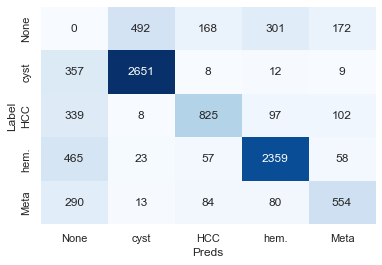

In [12]:
tics = ["cyst", "HCC", "hem.", "Meta"]
sns.heatmap(heat[:, :].astype(np.int16), cmap="Blues", annot=True, fmt='d', cbar=False, xticklabels=["None"] + tics, yticklabels=["None"] + tics)
plt.xlabel("Preds")
plt.ylabel("Label")
# plt.savefig(r"D:/Users/hara.e/Dropbox/ゼミ/AMED/fig/heatmap_centernet_stepwise2.pdf")

In [13]:
precision = []
for i in range(len(heat)):
    precision.append(heat[i, i] / heat[: , i].sum())

print(precision[1: ])
np.mean(precision[1: ])

[0.8318167555695011, 0.7224168126094571, 0.828009828009828, 0.6189944134078212]


0.7503094523991518

In [14]:
recall = []
for i in range(len(heat)):
    recall.append(heat[i, i] / heat[i].sum())

print(recall[1: ])
np.mean(recall[1: ])

[0.8729008890352321, 0.6017505470459519, 0.7964213369345037, 0.5426052889324192]


0.7034195154870267

In [15]:
f1 =[]
for p, r in zip(precision, recall):
    f1.append(2 * p * r / (p + r))
print(f1[1: ])
np.mean(f1[1: ])

[0.8518637532133676, 0.6565857540787903, 0.8119084494923421, 0.5782881002087683]


D:\Users\hara.e\AppData\Local\Continuum\miniconda3\envs\amed\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


0.724661514248317